In [2]:
suppressPackageStartupMessages({
library(dplyr)
library(Seurat)
library(ggplot2)
library(org.Mm.eg.db)
library(EnsDb.Mmusculus.v79)
library(TxDb.Mmusculus.UCSC.mm10.ensGene)
library(tibble)
library(reshape2)
library(viridis)
library(stringr)
})

In [3]:
# Define functions

# Set dplyr as default function for select, filter, and rename
select <- dplyr::select
filter <- dplyr::filter
rename <- dplyr::rename

# Pdf exporting function to maintain naming scheme for filenames
make_pdf <- function(object, filename, w, h){
    out_name <- paste0(format(Sys.Date(), "%y%m%d"),"_",filename,".pdf")
    pdf(out_name, width=w, height=h)
        plot(object)
    dev.off()
}

In [4]:
# Set working directory
setwd("/staging/leuven/stg_00041/Ryan/RA004_XHetDel/deep_seq/data/Ryan_Allsop/zUMI_out/")

In [5]:
escapees <- c("1810030O07Rik","2010000l03Rik","2010308F09Rik","2610029G23Rik","5530601H04Rik","6720401G13Rik","Abcd1","Araf","Atp6ap2","BC022960","Bgn","Car5b","D330035K16Rik","D930009K15Rik","Ddx3x","Eif1ax","Eif2s3x","Fam50a","Flna","Ftsj1","Fundc1","Gdi1","Gemin8","Gpkow","Huwe1","Idh3g","Igbp1","Ikbkg","Kdm5c","Kdm6a","Lamp2","Maged1","Mbtps2","Med14","Mid1","Mmgt1","Mpp1","Msl3","Ndufb11","Nkap","Ogt","Pbdc1","Pdha1","Prdx4","Rbm3","Renbp","Sh3bgrl","Shroom4","Sms","Suv39h1","Syap1","Tbc1d25","Timp1","Trap1a","Uba1","Usp9x","Utp14a","Uxt","Xist","Yipf6")

In [6]:
myPalette <- list("#77270d", "#ee8866", "#d6c941", "#eedd88", "#aaaa00", "#4ed641", "#44bb99", "#41d6c9", "#414ed6", "#77aadd", "#AC8CC1","#ffaabb")
names(myPalette) <- c("bold_red", "red", "bold_yellow", "yellow", "bold_green", "green", "bold_cyan", "cyan", "bold_blue", "blue", "bold_magenta", "magenta")

In [7]:
# Generate metadata tables
gene_metadata <- left_join(
                 AnnotationDbi::select(EnsDb.Mmusculus.v79,
                   keys=keys(EnsDb.Mmusculus.v79, keytype="GENEID"),
                   columns=c("SYMBOL","GENESEQSTART", "GENESEQEND"),
                   keytype="GENEID"),
                AnnotationDbi::select(TxDb.Mmusculus.UCSC.mm10.ensGene,
                   keys=keys(TxDb.Mmusculus.UCSC.mm10.ensGene, keytype="GENEID"), 
                   column="CDSCHROM",
                   keytype="GENEID"),
                by="GENEID"
            )

'select()' returned 1:1 mapping between keys and columns



In [8]:
seurat_cast <- readRDS("240424_Cast_seurat_obj.rds")
seurat_mus <- readRDS("240424_Mus_seurat_obj.rds")

In [9]:
corrected_celltypes <- read.table("240424_corrected_celltype.csv", sep=",")

In [10]:
cast_melt <- seurat_cast@assays$UMI@counts %>%
    as.data.frame() %>%
    rownames_to_column("gene_id") %>%
    mutate(GENEID=gsub("\\.[0-9]+$", "", .$gene_id)) %>%
    left_join(gene_metadata) %>%
    filter(CDSCHROM %in% c(unlist(lapply(1:19, function(x){paste0("chr",x)})), "chrX", "chrY")) %>%
    mutate(GENELENGTH=GENESEQEND-GENESEQSTART) %>%
    melt(id.vars = c("gene_id", "GENEID", "SYMBOL", "GENESEQSTART", "GENESEQEND", "CDSCHROM", "GENELENGTH")) %>%
    select(-gene_id) %>%
    rename(Well_cell_line=variable) %>%
    mutate(Cell_type=gsub(pattern = "[A-Z][0-9]{1,2}_", replacement = "", x=.$Well_cell_line)) %>%
    dplyr::rename(Cast=value)

mus_melt <- seurat_mus@assays$UMI@counts %>%
    as.data.frame() %>%
    rownames_to_column("gene_id") %>%
    mutate(GENEID=gsub("\\.[0-9]+$", "", .$gene_id)) %>%
    left_join(gene_metadata) %>%
    filter(CDSCHROM %in% c(unlist(lapply(1:19, function(x){paste0("chr",x)})), "chrX", "chrY")) %>%
    mutate(GENELENGTH=GENESEQEND-GENESEQSTART) %>%
    melt(id.vars = c("gene_id", "GENEID", "SYMBOL", "GENESEQSTART", "GENESEQEND", "CDSCHROM", "GENELENGTH")) %>%
    select(-gene_id) %>%
    rename(Well_cell_line=variable) %>%
    mutate(Cell_type=gsub(pattern = "[A-Z][0-9]{1,2}_", replacement = "", x=.$Well_cell_line)) %>%
    dplyr::rename(Mus=value)

Joining, by = "GENEID"
Joining, by = "GENEID"


In [11]:
counts_melt <- left_join(cast_melt, mus_melt) %>% 
    mutate(total_counts=Cast+Mus) %>%
    mutate(RPK_total=total_counts/GENELENGTH,
           RPK_cast=Cast/GENELENGTH,
           RPK_mus=Mus/GENELENGTH) %>%
    left_join(summarize(group_by(., Well_cell_line),
                        scaling_factor_total=(sum(na.omit(RPK_total))/1e6),
                        scaling_factor_cast=(sum(na.omit(RPK_cast))/1e6),
                        scaling_factor_mus=(sum(na.omit(RPK_mus))/1e6))) %>%
    mutate(TPM_total=RPK_total/scaling_factor_total,
           TPM_cast=RPK_cast/scaling_factor_total,
           TPM_mus=RPK_mus/scaling_factor_total) %>%
    left_join(corrected_celltypes[,c("Well_cell_line", "new_cell_type")]) %>%
    select(-Cell_type) %>%
    rename(Cell_type=new_cell_type)

counts_melt %>% head

Joining, by = c("GENEID", "SYMBOL", "GENESEQSTART", "GENESEQEND", "CDSCHROM", "GENELENGTH", "Well_cell_line", "Cell_type")
Joining, by = "Well_cell_line"
Joining, by = "Well_cell_line"


,GENEID,SYMBOL,GENESEQSTART,GENESEQEND,CDSCHROM,GENELENGTH,Well_cell_line,Cast,Mus,total_counts,RPK_total,RPK_cast,RPK_mus,scaling_factor_total,scaling_factor_cast,scaling_factor_mus,TPM_total,TPM_cast,TPM_mus,Cell_type
,<chr>,<chr>,<int>,<int>,<chr>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,ENSMUSG00000000001,Gnai3,108107280,108146146,chr3,38866,J9_XY,1,1,2,5.145886e-05,2.572943e-05,2.572943e-05,1.136715e-05,5.834961e-06,5.532191e-06,4.5269789,2.263489,2.2634895,XMusY
2,ENSMUSG00000000028,Cdc45,18780447,18811987,chr16,31540,J9_XY,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,1.136715e-05,5.834961e-06,5.532191e-06,0.0000000,0.000000,0.0000000,XMusY
3,ENSMUSG00000000037,Scml2,161117193,161258213,chrX,141020,J9_XY,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,1.136715e-05,5.834961e-06,5.532191e-06,0.0000000,0.000000,0.0000000,XMusY
4,ENSMUSG00000000056,Narf,121237253,121255856,chr11,18603,J9_XY,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,1.136715e-05,5.834961e-06,5.532191e-06,0.0000000,0.000000,0.0000000,XMusY
5,ENSMUSG00000000078,Klf6,5861489,5870393,chr13,8904,J9_XY,1,1,2,2.246181e-04,1.123091e-04,1.123091e-04,1.136715e-05,5.834961e-06,5.532191e-06,19.7602834,9.880142,9.8801417,XMusY
6,ENSMUSG00000000085,Scmh1,120405281,120530186,chr4,124905,J9_XY,0,1,1,8.006085e-06,0.000000e+00,8.006085e-06,1.136715e-05,5.834961e-06,5.532191e-06,0.7043175,0.000000,0.7043175,XMusY


In [12]:
rm(seurat_cast)
rm(seurat_mus)
rm(cast_melt)
rm(mus_melt)

In [13]:
non_allelic_counts <- counts_melt %>%
    select(GENEID, Well_cell_line, Cell_type, TPM_cast, TPM_mus, TPM_total, CDSCHROM) %>%
    filter(CDSCHROM %in% unlist(lapply(1:19, function(x){paste0("chr",x)}))) %>%
    group_by(GENEID, Cell_type) %>%
    summarize(meanVal=mean(TPM_total, na.rm=TRUE)) %>%
    dcast(GENEID~Cell_type) %>%
    column_to_rownames("GENEID")
non_allelic_counts %>% head

`summarise()` has grouped output by 'GENEID'. You can override using the `.groups` argument.
Using meanVal as value column: use value.var to override.



,Deletion 1,Deletion 2,Deletion 3,XCastOMus,XMusOCast,XMusY,XX,NA
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSMUSG00000000001,10.5016906,9.6933304,9.922688,14.1087779,13.4188291,13.2291052,11.6601002,22.988691
ENSMUSG00000000028,3.6829902,4.3609814,4.007067,3.9572238,8.5474723,4.1783030,5.5872938,7.082106
ENSMUSG00000000056,5.2533007,4.1711947,3.442884,3.2649030,4.9663048,4.0116067,3.6334665,0.000000
ENSMUSG00000000058,0.2676866,0.1431354,0.000000,0.0000000,0.0000000,NaN,0.0000000,0.000000
ENSMUSG00000000078,12.0124521,4.0866862,4.819725,8.2803765,3.0265187,12.4377530,6.8156951,0.000000
ENSMUSG00000000085,0.3594588,0.7557649,0.934453,0.4872625,0.4391556,0.5428513,0.6247553,1.788316


In [13]:
correlation_plot_data <- melt(cor(na.omit(non_allelic_counts))) %>%
    mutate(xpos=case_when(Var1=="XX" ~ 1,
                          Var1=="XCastOMus" ~ 2,
                          Var1=="XMusOCast" ~ 3,
                          Var1=="XMusY" ~ 4,
                          Var1=="Deletion 1" ~ 5,
                          Var1=="Deletion 2" ~ 6,
                          Var1=="Deletion 3" ~ 7),
           ypos=case_when(Var2=="XX" ~ 7,
                          Var2=="XCastOMus" ~ 6,
                          Var2=="XMusOCast" ~ 5,
                          Var2=="XMusY" ~ 4,
                          Var2=="Deletion 1" ~ 3,
                          Var2=="Deletion 2" ~ 2,
                          Var2=="Deletion 3" ~ 1)) %>%
    mutate(value=as.double(sprintf("%.2f", value)))

In [14]:
options(repr.plot.width=3, repr.plot.height=2.5)
correlation_plot <- ggplot(correlation_plot_data) +
    geom_rect(aes(xmin=xpos-0.5, xmax=xpos+0.5, ymin=ypos-0.5, ymax=ypos+0.5, fill=value)) +
    scale_fill_viridis(limits=c(0.75,1), option="H", name="Correlation\ncoefficients") +
    geom_text(aes(label=value, x=xpos, y=ypos), color="white", size=7*0.352777778) +
    geom_text(data=unique(correlation_plot_data[,c("xpos", "Var1")]), aes(y=7.75, x=xpos, label=Var1), 
              angle=45, 
              hjust=0, 
              size=7*0.352777778) +
    geom_text(data=unique(correlation_plot_data[,c("ypos", "Var2")]), aes(x=0.25, y=ypos, label=Var2),
              hjust=1,
              size=7*0.352777778) +
    coord_cartesian(clip="off") +
    theme_void() +
    theme(legend.title=element_text(size=7), legend.text=element_text(size=7))

Warning message:
"Removed 15 rows containing missing values (`geom_rect()`)."
Warning message:
"Removed 15 rows containing missing values (`geom_text()`)."
Warning message:
"Removed 1 rows containing missing values (`geom_text()`)."
Warning message:
"Removed 1 rows containing missing values (`geom_text()`)."


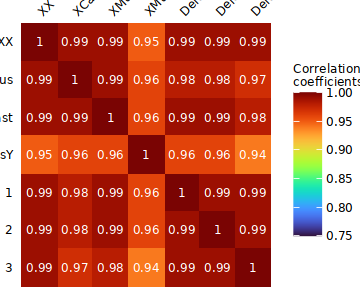

In [15]:
correlation_plot

In [19]:
make_pdf(correlation_plot, "corr_plot", w=2.5, h=2.5)

Warning message:
"Removed 15 rows containing missing values (`geom_rect()`)."
Warning message:
"Removed 15 rows containing missing values (`geom_text()`)."
Warning message:
"Removed 1 rows containing missing values (`geom_text()`)."
Warning message:
"Removed 1 rows containing missing values (`geom_text()`)."


png 
  2